### Incremental DPP using the Matrix Inversion Lemma

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from scipy.interpolate import fitpack,bisplrep,bisplev
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded.")

Packages loaded.


### Util

### Incremental Determinant computation
Suppose $M \in \mathbb{R}^{(N+1) \times (N+1)}$, $A \in \mathbb{R}^{N \times N}$,
$\mathbf{b} \in \mathbb{R}^N$, and $c \in \mathbb{R}$. 

$$
\det M
=
\det \left(
\begin{bmatrix}
A & \mathbf{b} \\
\mathbf{b}^T & c
\end{bmatrix}
\right)
= \det(A) (c - \mathbf{b}^T A^{-1} \mathbf{b})
$$

In [2]:
def kernel_se(X1,X2,hyp={'g':1.0,'l':1.0}):
    """
        Squared exponential (SE) kernel function
    """
    K = hyp['g']*np.exp(-cdist(X1,X2,'sqeuclidean')/(2*hyp['l']*hyp['l']))
    return K

def block_mtx(M11,M12,M21,M22):
    M_upper = np.concatenate((M11,M12),axis=1)
    M_lower = np.concatenate((M21,M22),axis=1)
    M = np.concatenate((M_upper,M_lower),axis=0)
    return M

def inv_inc(inv_A,b,c):
    """
        Incremental inverse using matrix inverse lemma
    """
    k   = c - b.T @ inv_A @ b
    M11 = inv_A + 1/k * inv_A @ b @ b.T @ inv_A
    M12 = -1/k * inv_A @ b
    M21 = -1/k * b.T @ inv_A
    M22 = 1/k
    M   = block_mtx(M11=M11,M12=M12,M21=M21,M22=M22)
    return M

def det_inc(det_A,inv_A,b,c):
    """
        Incremental determinant computation
    """
    out = det_A * (c - b.T @ inv_A @ b)
    return out
print ("Done.")

Done.


### Time check of the original and incremental k-DPP

In [3]:
# Prepare dataset
np.random.seed(seed=0)
n_total     = 4000
n_select    = 100
xs_total    = np.random.rand(n_total,2)
hyp         = {'g':1.0,'l':0.1}
print ("Done.")

Done.


### 1. Original k-DPP (k-dpp)

In [4]:
np.random.seed(seed=0)
n_total     = xs_total.shape[0]
idxs_remain = np.arange(0,n_total,1,dtype=np.int32)
idxs_select = []
tic = datetime.now() # tic
tocs_kdpp = []
for i_idx in range(n_select+1): # for all samples
    n_remain  = len(idxs_remain)
    if i_idx == 0:
        idx_select = np.random.permutation(n_total)[0] # first sample random
    else:
        xs_select = xs_total[idxs_select,:]
        dets      = np.zeros(shape=n_remain)
        for r_idx in range(n_remain): # for the remained indices
            idx_check  = idxs_remain[r_idx]
            idxs_check = idxs_select + [idx_check]
            xs_check   = xs_total[idxs_check,:]
            # Compute the determinant of the kernel matrix 
            K_check    = kernel_se(xs_check,xs_check,hyp=hyp)
            det_check  = np.linalg.det(K_check)
            # Append the determinant
            dets[r_idx] = det_check
        # Get the index with the highest determinant
        idx_select = idxs_remain[np.where(dets == np.amax(dets))[0][0]]
    # Remove currently selected index from 'idxs_remain'
    idxs_remain = idxs_remain[idxs_remain != idx_select]
    # Append currently selected index to 'idxs_select'
    idxs_select.append(idx_select)
    # Check time
    toc = (datetime.now()-tic).total_seconds() # toc
    tocs_kdpp.append(toc)
    if (i_idx%(n_select//5)) == 0:
        n_selected = len(idxs_select)
        n_remain = len(idxs_remain)
        print ("   k-DPP [%d/%d] n_selected:[%d] n_remain:[%d] [%.3f]sec"%
               (i_idx,n_select,n_selected,n_remain,toc))
# Select the subset from 'xs_total' with removing the first sample
idxs_select = idxs_select[1:] # excluding the first one
idxs_select = np.array(idxs_select)
xs_kdpp     = xs_total[idxs_select]
print ("Done.")

   k-DPP [0/100] n_selected:[1] n_remain:[3999] [0.000]sec
   k-DPP [20/100] n_selected:[21] n_remain:[3979] [0.785]sec
   k-DPP [40/100] n_selected:[41] n_remain:[3959] [2.286]sec
   k-DPP [60/100] n_selected:[61] n_remain:[3939] [4.949]sec
   k-DPP [80/100] n_selected:[81] n_remain:[3919] [9.366]sec
   k-DPP [100/100] n_selected:[101] n_remain:[3899] [19.036]sec
Done.


### 2. Incremental k-DPP (ik-dpp)

In [5]:
np.random.seed(seed=0)
n_total       = xs_total.shape[0]
idxs_remain   = np.arange(0,n_total,1,dtype=np.int32)
idxs_selected = []
tic           = datetime.now() # tic
tocs_ikdpp     = []
for i_idx in range(n_select+1): # for all samples
    n_remain = len(idxs_remain)
    if i_idx == 0: # for the first sample
        idx_selected = np.random.permutation(n_total)[0] # first sample random
        q            = 1.0
        det_K_prev   = q
        K_inv_prev   = 1/q*np.ones(shape=(1,1))
    else:
        xs_selected  = xs_total[idxs_selected,:] # currently selected inputs
        # Buffers
        dets_remain  = np.zeros(shape=n_remain)
        det_K_prev_list,K_inv_prev_list = [],[]
        for r_idx in range(n_remain): # for all remaining indices
            # Compute the determinant of the appended kernel matrix 
            k_vec     = kernel_se(
                X1  = xs_selected,
                X2  = xs_total[idxs_remain[r_idx],:].reshape(1,-1),
                hyp = hyp)
            q         = 1.0
            det_check = det_inc(
                det_A = det_K_prev,
                inv_A = K_inv_prev,
                b     = k_vec,
                c     = q)
            # Append the determinant
            dets_remain[r_idx] = det_check
        # Get the index with the highest determinant
        idx_temp     = np.where(dets_remain == np.amax(dets_remain))[0][0]
        idx_selected = idxs_remain[idx_temp]
        # Compute 'det_K_prev' and 'K_inv_prev'
        det_K_prev = dets_remain[idx_temp]
        k_vec      = kernel_se(
            xs_selected,
            xs_total[idx_selected,:].reshape(1,-1),
            hyp=hyp)
        q          = 1
        K_inv_prev = inv_inc(
            inv_A = K_inv_prev,
            b     = k_vec,
            c     = q)
    # Remove currently selected index from 'idxs_remain'
    idxs_remain = idxs_remain[idxs_remain != idx_selected]
    # Append currently selected index to 'idxs_select'
    idxs_selected.append(idx_selected)
    # Check time
    toc = (datetime.now()-tic).total_seconds() # toc
    tocs_ikdpp.append(toc)
    if (i_idx%(n_select//5)) == 0:
        n_selected = len(idxs_selected)
        print ("  ik-DPP [%d/%d] n_selected:[%d] n_remain:[%d] [%.3f]sec"%
               (i_idx,n_select,n_selected,n_remain,toc))
# Select the subset from 'xs_total' with removing the first sample
idxs_selected = idxs_selected[1:] # excluding the first one
idxs_selected = np.array(idxs_selected)
xs_ikdpp       = xs_total[idxs_selected]
# Random samples
idxs_random   = np.random.permutation(n_total)[:n_select]
xs_random     = xs_total[idxs_random]
print ("Done.")

  ik-DPP [0/100] n_selected:[1] n_remain:[4000] [0.000]sec
  ik-DPP [20/100] n_selected:[21] n_remain:[3980] [0.656]sec
  ik-DPP [40/100] n_selected:[41] n_remain:[3960] [1.249]sec
  ik-DPP [60/100] n_selected:[61] n_remain:[3940] [1.868]sec
  ik-DPP [80/100] n_selected:[81] n_remain:[3920] [2.696]sec
  ik-DPP [100/100] n_selected:[101] n_remain:[3900] [4.060]sec
Done.


### 3. Truncated Incremental k-DPP (tik-DPP)

In [12]:
# Truncation parameter
tik_upperbound = 10
# tik-DPP
np.random.seed(seed=0)
n_total       = xs_total.shape[0]
idxs_remain   = np.arange(0,n_total,1,dtype=np.int32)
idxs_selected = []
tic           = datetime.now() # tic
tocs_tikdpp     = []
for i_idx in range(n_select+1): # for all samples
    n_remain = len(idxs_remain)
    if i_idx == 0: # for the first sample
        idx_selected = np.random.permutation(n_total)[0] # first sample random
        q            = 1.0
        det_K_prev   = q
        K_inv_prev   = 1/q*np.ones(shape=(1,1))
    else:
        xs_selected  = xs_total[idxs_selected,:] # currently selected inputs
        # Buffers
        dets_remain  = np.zeros(shape=n_remain)
        det_K_prev_list,K_inv_prev_list = [],[]
        for r_idx in np.random.permutation(n_remain)[:min(n_remain,tik_upperbound)]:
            # Compute the determinant of the appended kernel matrix 
            k_vec     = kernel_se(
                X1  = xs_selected,
                X2  = xs_total[idxs_remain[r_idx],:].reshape(1,-1),
                hyp = hyp)
            q         = 1.0
            det_check = det_inc(
                det_A = det_K_prev,
                inv_A = K_inv_prev,
                b     = k_vec,
                c     = q)
            # Append the determinant
            dets_remain[r_idx] = det_check
        # Get the index with the highest determinant
        idx_temp     = np.where(dets_remain == np.amax(dets_remain))[0][0]
        idx_selected = idxs_remain[idx_temp]
        # Compute 'det_K_prev' and 'K_inv_prev'
        det_K_prev = dets_remain[idx_temp]
        k_vec      = kernel_se(
            xs_selected,
            xs_total[idx_selected,:].reshape(1,-1),
            hyp=hyp)
        q          = 1
        K_inv_prev = inv_inc(
            inv_A = K_inv_prev,
            b     = k_vec,
            c     = q)
    # Remove currently selected index from 'idxs_remain'
    idxs_remain = idxs_remain[idxs_remain != idx_selected]
    # Append currently selected index to 'idxs_select'
    idxs_selected.append(idx_selected)
    # Check time
    toc = (datetime.now()-tic).total_seconds() # toc
    tocs_tikdpp.append(toc)
    if (i_idx%(n_select//5)) == 0:
        n_selected = len(idxs_selected)
        print (" tik-DPP [%d/%d] n_selected:[%d] n_remain:[%d] [%.3f]sec"%
               (i_idx,n_select,n_selected,n_remain,toc))
# Select the subset from 'xs_total' with removing the first sample
idxs_selected = idxs_selected[1:] # excluding the first one
idxs_selected = np.array(idxs_selected)
xs_tikdpp     = xs_total[idxs_selected]
print ("Done.")

 tik-DPP [0/100] n_selected:[1] n_remain:[4000] [0.001]sec
 tik-DPP [20/100] n_selected:[21] n_remain:[3980] [0.006]sec
 tik-DPP [40/100] n_selected:[41] n_remain:[3960] [0.010]sec
 tik-DPP [60/100] n_selected:[61] n_remain:[3940] [0.015]sec
 tik-DPP [80/100] n_selected:[81] n_remain:[3920] [0.024]sec
 tik-DPP [100/100] n_selected:[101] n_remain:[3900] [0.040]sec
Done.


### 4. Random samples

In [13]:
idxs_random   = np.random.permutation(n_total)[:n_select]
xs_random     = xs_total[idxs_random]
print ("Done.")

Done.


### Plot elapsed time of k-DPP, ik-DPP, and tik-DPP

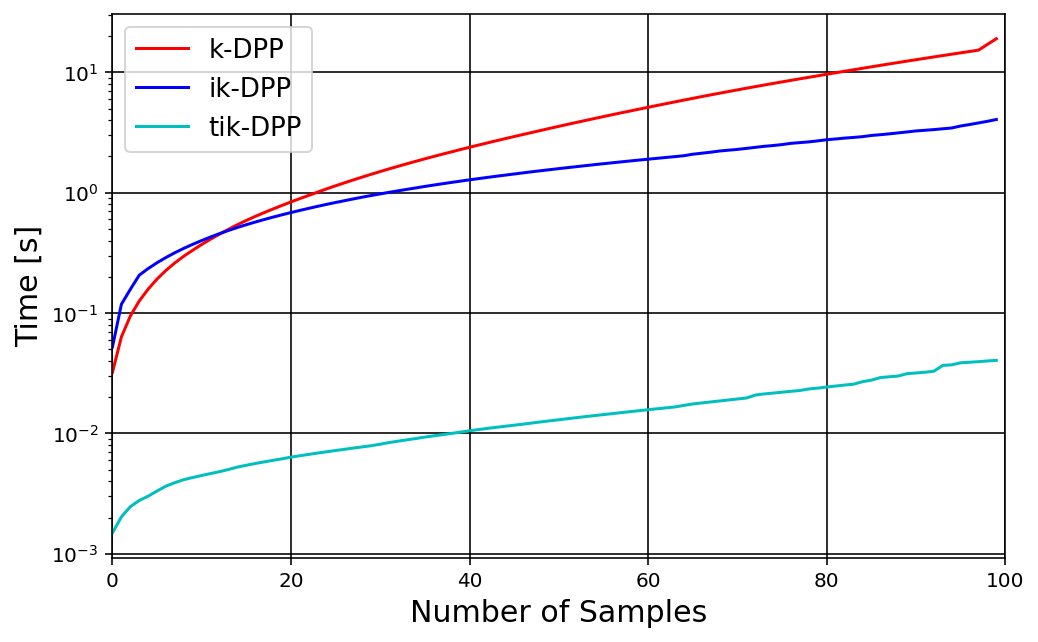

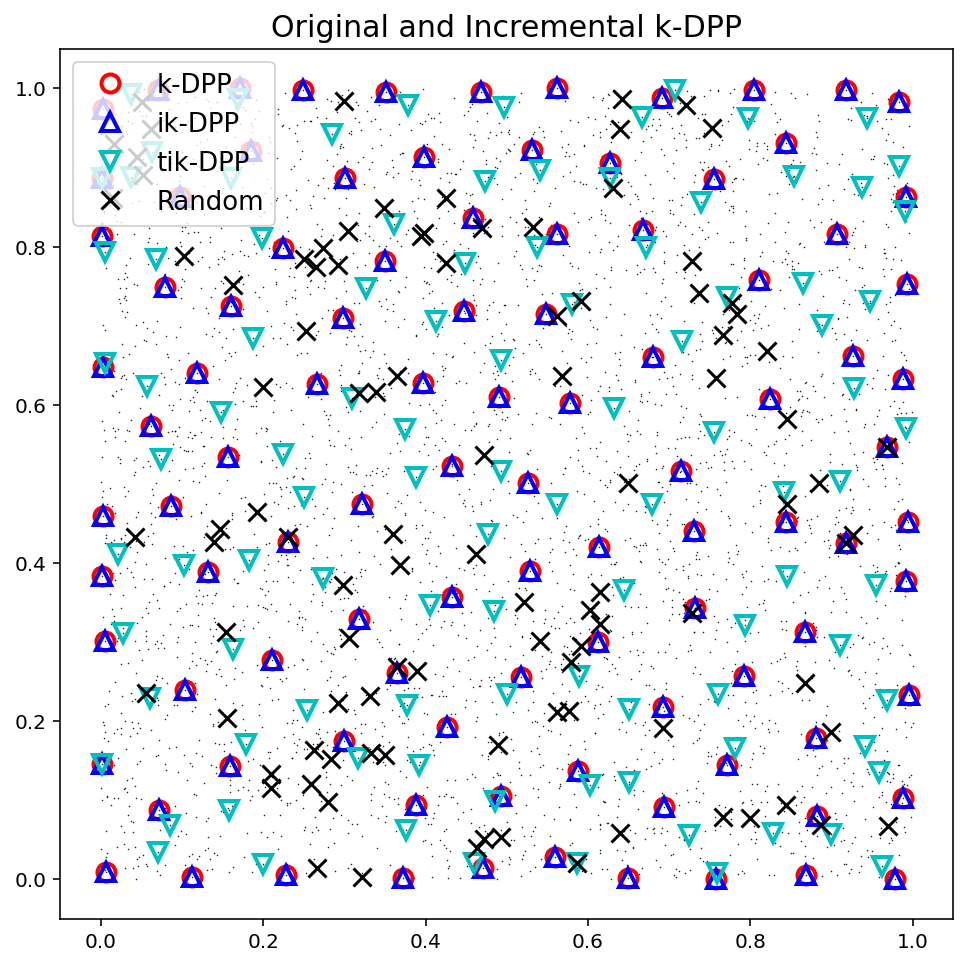

In [14]:
plt.figure(figsize=(8,5))
plt.plot(tocs_kdpp[1:],'-',color='r',label='k-DPP')
plt.plot(tocs_ikdpp[1:],'-',color='b',label='ik-DPP')
plt.plot(tocs_tikdpp[1:],'-',color='c',label='tik-DPP')
plt.xlim([0,len(tocs_kdpp)-1]); plt.yscale('log')
plt.grid(color='k',ls='-')
plt.xlabel('Number of Samples',fontsize=15)
plt.ylabel('Time [s]',fontsize=15)
plt.legend(fontsize=13,loc='upper left')
plt.show()

# Plot the DPP results for check
plt.figure(figsize=(8,8))
plt.plot(xs_total[:,0],xs_total[:,1],'.',color='k',lw=0.1,
         markeredgewidth=1/2,ms=1/2)
plt.plot(xs_kdpp[:,0],xs_kdpp[:,1],
         'o',ms=9,mfc='None',mec='r',markeredgewidth=2,
         label='k-DPP')
plt.plot(xs_ikdpp[:,0],xs_ikdpp[:,1],
         '^',ms=9,mfc='None',mec='b',markeredgewidth=2,
         label='ik-DPP')
plt.plot(xs_tikdpp[:,0],xs_tikdpp[:,1],
         'v',ms=9,mfc='None',mec='c',markeredgewidth=2,
         label='tik-DPP')
plt.plot(xs_random[:,0],xs_random[:,1],
         'x',ms=9,mfc='None',mec='k',markeredgewidth=1.5,
         label='Random')
plt.legend(fontsize=13,loc='upper left')
plt.title("Original and Incremental k-DPP",fontsize=15)
plt.show()